# CIS520 Project 
## Part 2 - Model Selection XGBoost Model
**Notes**
* normalization by sklearn MinMaxScaler
* PCA analysis and dimension reduction
* XGBoost Model, parameter search

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_validate,cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb   # pip install xgboost
import seaborn as sns
sns.set(color_codes=True)

In [4]:
engine=sqlite3.connect('stock_price_DB')

In [5]:
# hp ge amd google

###### Select stock data and convert to ndarray
* Set `date` as index
* drop NaN items

**AMD**

In [6]:
amd_df=pd.read_sql_query('select * from amd', engine).dropna()
data_df=amd_df.astype('float')
data_array=amd_df.values

In [7]:
amd_df.head()

,open,high,low,close,adj_close,volume,adx,adxr,apo,aroon_up,...,spinning_top,stalled_pattern,stick_sandwich,takuri,tasuki_gap,thrusting,tri_star,unique_three_river,xside_three_methods,trend
88,5.87,6.06,5.79,5.94,5.94,20247100,49.269213,42.897807,0.735513,0.0,...,100,0,0,0,0,0,0,0,0,0.0
89,5.85,6.10,5.72,5.78,5.78,31086500,48.163275,43.712058,0.663846,0.0,...,0,0,0,0,0,0,0,0,0,0.0
90,5.80,5.85,5.59,5.66,5.66,37557200,46.558331,44.306165,0.595000,8.0,...,0,0,0,0,0,0,0,0,0,0.0
91,5.62,5.65,5.27,5.39,5.39,42759500,43.827405,44.249098,0.501474,4.0,...,0,0,0,0,0,0,0,0,0,0.0
92,5.22,5.45,5.05,5.31,5.31,31821800,40.820347,44.020791,0.421731,0.0,...,100,0,0,0,0,0,0,0,0,1.0


**Google**

In [19]:
google_df=pd.read_sql_query('select * from google', engine).set_index('date').dropna()
data_df=google_df.astype('float')
data_array=google_df.values

**GE**

In [9]:
ge_df=pd.read_sql_query('select * from ge', engine).set_index('date').dropna()
data_df=ge_df.astype('float')
data_array=ge_df.values

**HPQ**

In [10]:
hpq_df=pd.read_sql_query('select * from hpq', engine).set_index('date').dropna()
data_df=hpq_df.copy()
# data_df=ibm_df.drop(columns='date').dropna().astype('float')
data_array=hpq_df.values

In [11]:
data_df.head()

,open,high,low,close,volume,adx,adxr,apo,aroon_up,aroon_dn,...,stalled_pattern,stick_sandwich,takuri,tasuki_gap,thrusting,tri_star,unique_three_river,upside_gap_two_crows,xside_three_methods,trend
date,,,,,,,,,,,,,,,,,,,,,
1970-05-08 00:00:00,0.21049,0.21437,0.20280,0.20676,3293845,25.373567,25.410834,-0.009828,100.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
1970-05-11 00:00:00,0.20676,0.21049,0.20676,0.20676,3076491,26.104126,26.448963,-0.009387,96.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1970-05-12 00:00:00,0.20676,0.20676,0.20280,0.20280,5049455,27.045858,27.673730,-0.010502,100.0,24.0,...,0,0,0,0,0,0,0,0,0,0.0
1970-05-13 00:00:00,0.19908,0.19908,0.19516,0.19516,3444327,28.381329,28.691552,-0.011772,100.0,20.0,...,0,0,0,0,0,0,0,0,0,1.0
1970-05-14 00:00:00,0.19516,0.19908,0.18381,0.19908,8928500,30.184746,29.918340,-0.012723,100.0,16.0,...,0,0,0,0,0,0,0,0,0,1.0


### Further Feature Processing
* Split Feature and Label
* Normalization by std.scaler  $x_{std}=\frac{x-\mu}{\sigma}$
* PCA analysis

#### Normalization

In [14]:
X=data_df.values[:,:-1]
y=data_df.values[:,-1].astype(int)
sc = StandardScaler()
X_std=sc.fit_transform(X)

#### PCA Analysis

In [40]:
from sklearn.decomposition import PCA
pca=PCA()
X_pca=pca.fit_transform(X_std)
reconstruction_accuracy=np.cumsum(pca.explained_variance_ratio_)
# number of principal componenets required to achieve 98% reconstruction accuracy
d=min(np.where(reconstruction_accuracy>0.98)[0]) + 1 
print('dimension with 98% reconstruction accuracy is=',d)
X_pca=X_pca[:,:d+1]   # select first d principal components

dimension with 98% reconstruction accuracy is= 76


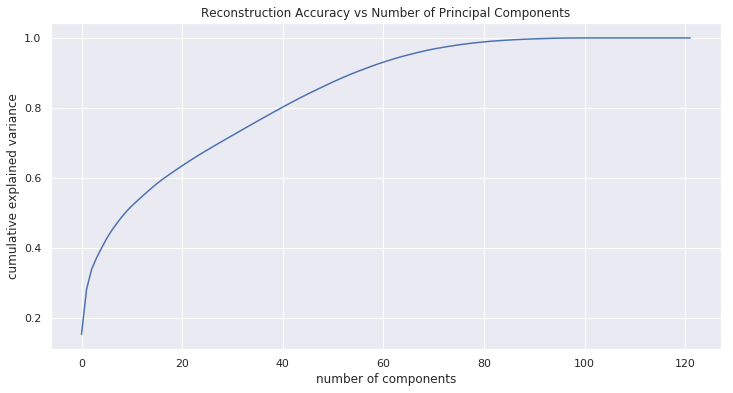

In [24]:
fig=plt.figure(figsize=(12,6))
plt.plot(reconstruction_accuracy,)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Reconstruction Accuracy vs Number of Principal Components')
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.3)

In [26]:
X_train.shape

(8390, 77)

### XGBoost Model

In [30]:
# ------- parameter of other three stock
# para_amd={'colsample_bytree': 0.8009662644666179, 'gamma': 0.3278613176903711, 
#        'learning_rate': 0.14561898628966952, 'max_depth': 3, 'n_estimators': 150, 
#        'subsample': 0.6093087742943303}
# para_hpq={'colsample_bytree': 0.8542703315240834, 'gamma': 0.29620728443102123,
#         'learning_rate': 0.043935123815999316, 'max_depth': 2, 'n_estimators': 150, 
#         'subsample': 0.8721230154351118}   # for ibm
# para_ge={'colsample_bytree': 0.7160455890242107, 'gamma': 0.47927074844159917, 
#              'learning_rate': 0.28414294322867695, 'max_depth': 2, 'n_estimators': 160,
#              'subsample': 0.9827203540505826}
xgb_model_google=xgb.XGBClassifier(booster='gbtree', colsample_bylevel=0.9919031664257336,gamma=0.1965488623333802,
                            learning_rate=0.17613966553134, max_depth=2, 
                            n_estimators=5,subsample=0.9179245214166594,n_jobs=8,
                            nthread=16, objective='binary:logistic')
xgb_model_google.fit(X_train, y_train)
y_pred_tr = xgb_model_google.predict(X_train)
y_pred_test = xgb_model_google.predict(X_test)
print('acc_predict',accuracy_score(y_pred_test, y_test))
print('acc_train',accuracy_score(y_pred_tr, y_train))

acc_predict 0.5625695216907676
acc_train 0.5541120381406436


#### Cross Validation

In [25]:
from scipy import stats
from sklearn.metrics import f1_score

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits=5, shuffle = True)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds.split(X):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds


/home/josephkeecaoqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    7.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.4s finished
/home/josephkeecaoqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    8.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.0s finished
/home/josephkeecaoqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    9.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.9s finished
/home/josephkeecaoqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    8.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.5s finished
/home/josephkeecaoqi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed:    9.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.1s finished
